## Scanpy `pbmc4k`

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

In [33]:
results_out_root = '/home/jupyter/data/10x/out/'
marker_genes_txt = '/home/jupyter/data/10x/pbmc_marker_genes.txt'

# input_roots = ['/home/jupyter/data/10x/out/pbmc4k__raw__mtx_output/',
#                '/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__raw__mtx_output/',
#                '/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.0625__raw__mtx_output/']
# output_prefix = 'pbmc4k_raw_joint'

input_roots = ['/home/jupyter/data/10x/out/pbmc4k__all_genes__11__final_3_weakreg__mtx_output/',
               '/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.25__all_genes__11__final_3_weakreg__mtx_output/',
               '/home/jupyter/data/10x/out/pbmc4k_ss_rate_0.125__all_genes__11__final_3_weakreg__mtx_output/']
output_prefix = 'pbmc4k_dtm_joint'

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = os.path.join(results_out_root, f'{output_prefix}.h5ad')

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.2 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [34]:
sc.settings.set_figure_params(dpi=80)

## Load marker genes

In [35]:
from collections import defaultdict
marker_genes_dict = defaultdict(list)

with open(marker_genes_txt, 'r') as f:
    while True:
        cluster_name = f.readline().strip()
        gene_name = f.readline().strip()
        sense = f.readline().strip()
        if sense == '+':
            sense = 1
        else:
            sense = -1
        if cluster_name == "":
            break
        marker_genes_dict[cluster_name].append((gene_name, sense))
        
all_marker_genes = []
for v in marker_genes_dict.values():
    all_marker_genes += [x[0] for x in v]
all_marker_genes = np.unique(all_marker_genes).tolist()

In [36]:
adatas = [sc.read_10x_mtx(
    input_root,
    var_names='gene_symbols',
    cache=True) for input_root in input_roots] 

... reading from cache file cache/home-jupyter-data-10x-out-pbmc4k__all_genes__11__final_3_weakreg__mtx_output-matrix.h5ad
... reading from cache file cache/home-jupyter-data-10x-out-pbmc4k_ss_rate_0.25__all_genes__11__final_3_weakreg__mtx_output-matrix.h5ad
... reading from cache file cache/home-jupyter-data-10x-out-pbmc4k_ss_rate_0.125__all_genes__11__final_3_weakreg__mtx_output-matrix.h5ad


In [37]:
# concatenate them into one adata object
adata = anndata.AnnData.concatenate(*adatas, batch_key='batch')

In [38]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [39]:
adata

AnnData object with n_obs × n_vars = 13683 × 17574 
    obs: 'batch'
    var: 'gene_ids'

## Preprocessing

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


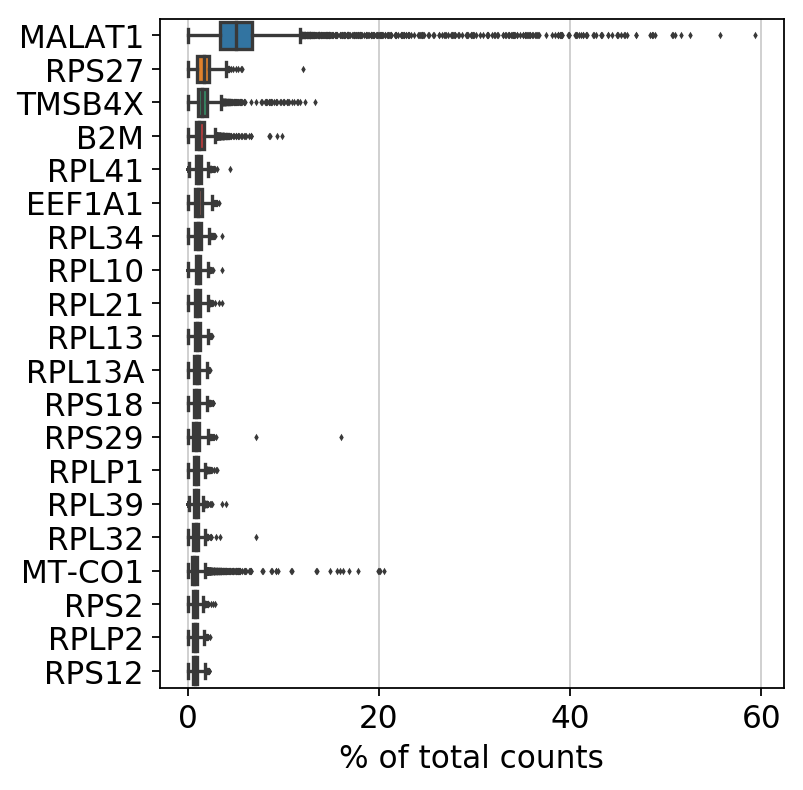

In [40]:
sc.pl.highest_expr_genes(adata, n_top=20, save="_" + output_prefix + '.pdf')

In [41]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=9)

filtered out 65 cells that haveless than 200 genes expressed
filtered out 2101 genes that are detectedin less than 9 cells


In [42]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

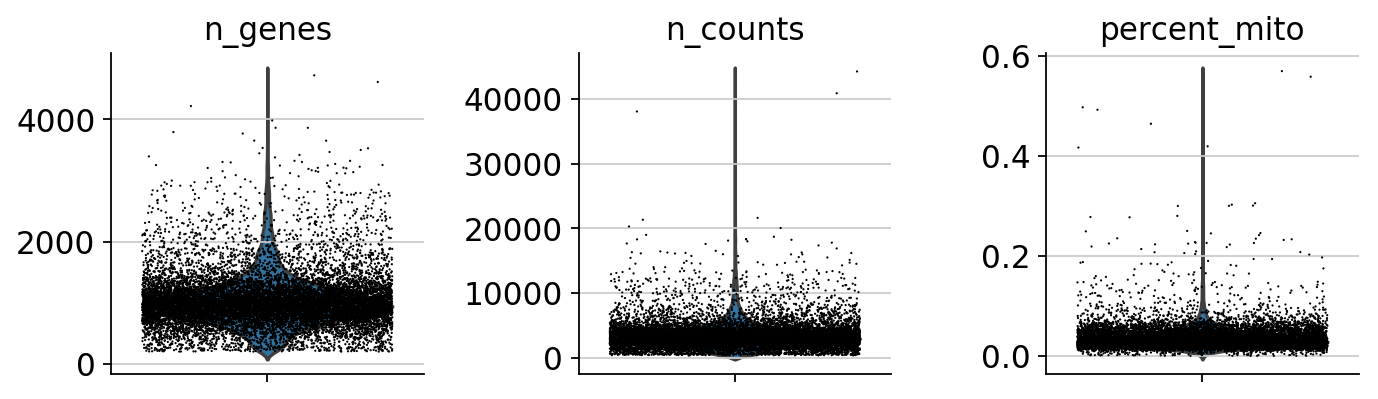

In [43]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

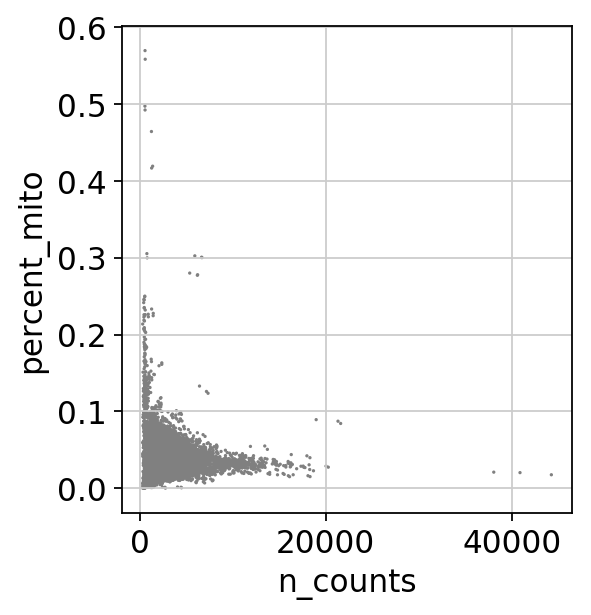

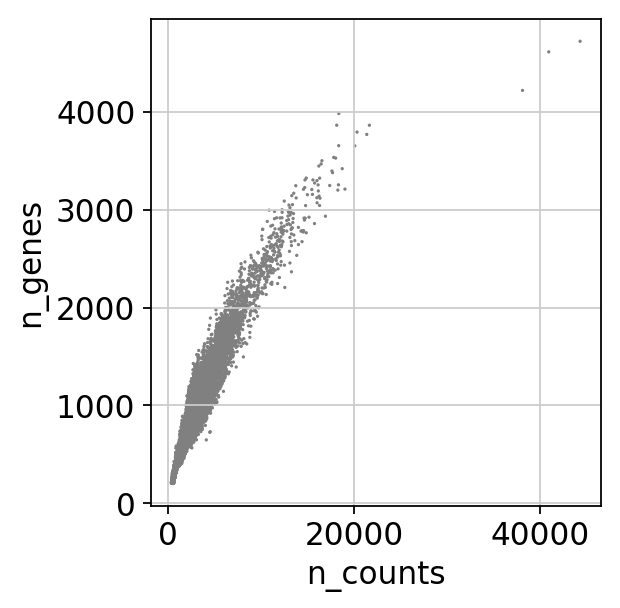

In [44]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [45]:
adata

AnnData object with n_obs × n_vars = 13618 × 15473 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [46]:
adata = adata[adata.obs['n_genes'] < 2000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [47]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [48]:
sc.pp.log1p(adata)

In [49]:
adata.raw = adata
raw_gene_names = adata.var.index

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


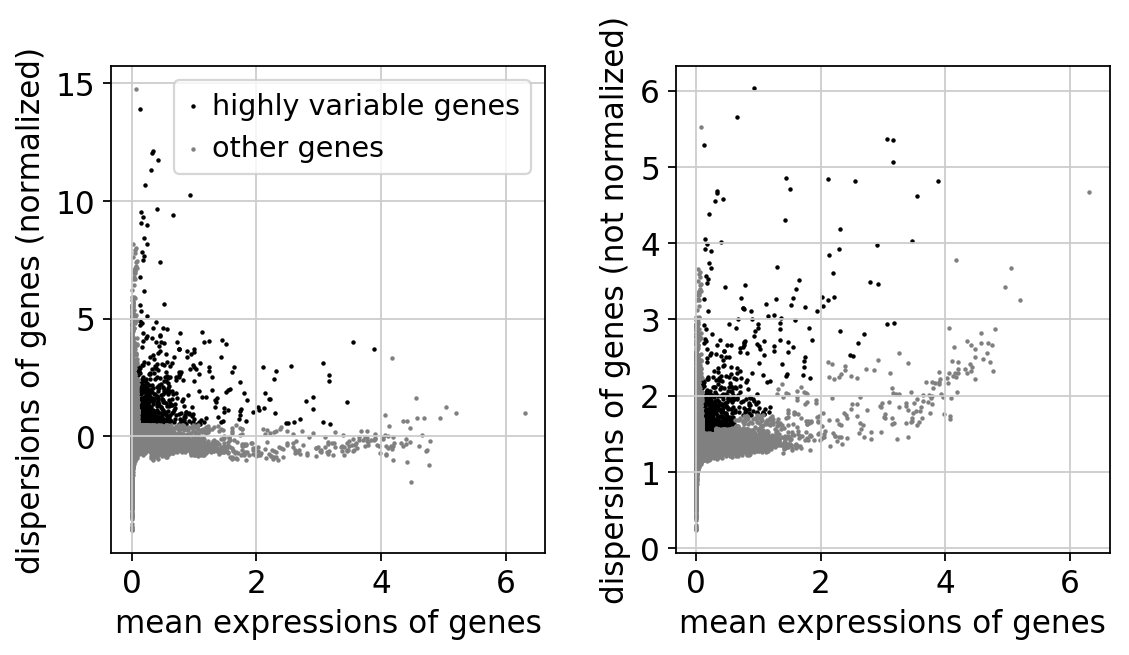

In [50]:
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [51]:
adata = adata[:, adata.var['highly_variable']]

In [52]:
# sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [53]:
sc.pp.scale(adata, max_value=10)

/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [54]:
adata

AnnData object with n_obs × n_vars = 11137 × 824 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Principal component analysis

In [55]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


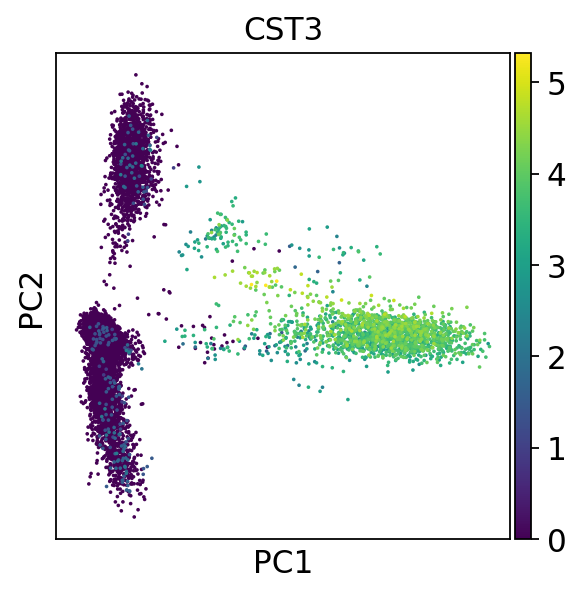

In [56]:
sc.pl.pca(adata, color='CST3')

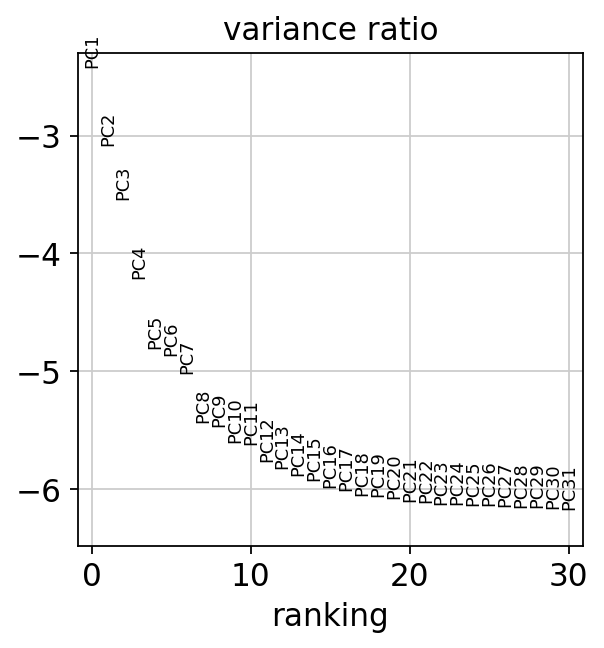

In [57]:
sc.pl.pca_variance_ratio(adata, log=True)

In [58]:
adata.write(results_file)

In [59]:
adata

AnnData object with n_obs × n_vars = 11137 × 824 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [60]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)


In [61]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


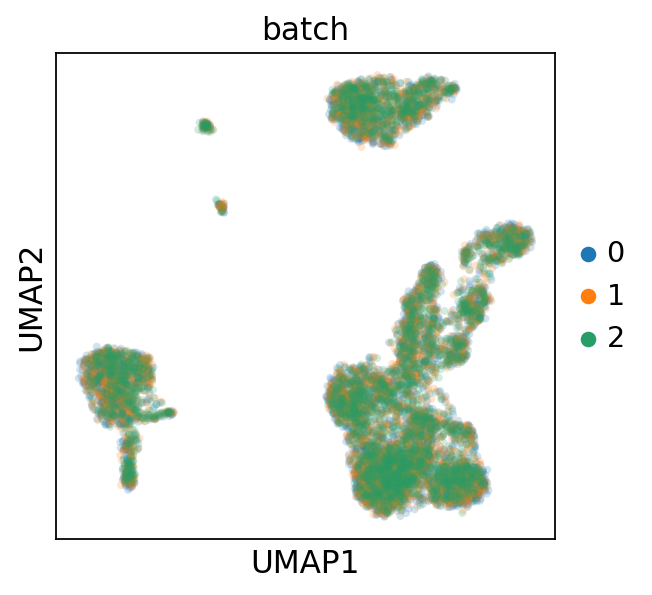

In [62]:
sc.pl.umap(adata, color='batch', alpha=0.2, s=50)

## Annotate and cluster

In [361]:
# raw -> 0.7
# dtm -> 1.0
louvain_resolution = 2.0
sc.tl.louvain(adata, resolution=louvain_resolution)

if 'cell_type' in adata.obs.columns:
    adata.obs = adata.obs.drop(columns=['cell_type'])
adata.obs.insert(len(adata.obs.columns), 'cell_type', adata.obs['louvain'].values.tolist())

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


In [362]:
considered_cell_types = list(marker_genes_dict.keys())

In [363]:
max_cluster_index = max([int(x) for x in adata.obs['louvain'].values.tolist()])
score_matrix = np.zeros((max_cluster_index + 1, len(considered_cell_types)))
for cluster_index in range(max_cluster_index + 1):
    print(cluster_index)
    cluster_adata = adata[adata.obs['louvain'] == str(cluster_index), :]
    for cell_type_index, cell_type in enumerate(considered_cell_types):
        cell_type_ann = marker_genes_dict[cell_type]
        score = 0.
        for gene_name, sense in cell_type_ann:
            try:
                score += np.sum(cluster_adata[:, gene_name].X * sense).item()
            except:
                pass
        score_matrix[cluster_index, cell_type_index] = score
        
cell_type_assignment = np.argmax(score_matrix, -1)
for i, v in enumerate(adata.obs['louvain'].values):
    adata.obs['cell_type'].values[i] = considered_cell_types[cell_type_assignment[int(v)]]

0


/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [364]:
cell_type_assignment = np.argmax(score_matrix, -1)
for i, v in enumerate(adata.obs['louvain'].values):
    adata.obs['cell_type'].values[i] = considered_cell_types[cell_type_assignment[int(v)]]

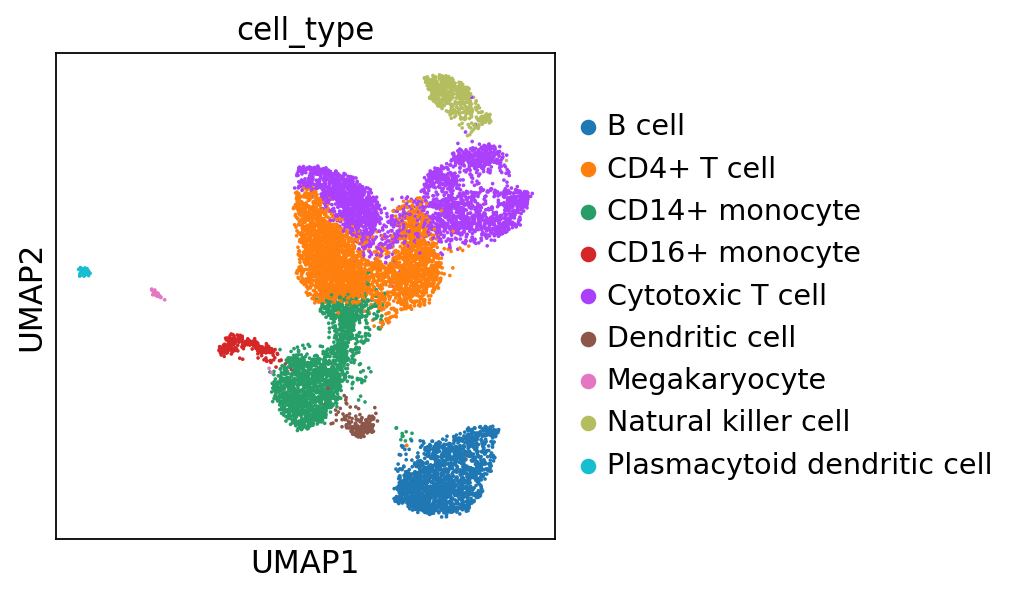

<Figure size 320x320 with 0 Axes>

In [404]:
import matplotlib.pylab as plt
sc.pl.umap(adata, color=['cell_type'], save="_" + output_prefix + '_big.pdf')
# sc.pl.umap(adata[adata.obs['cell_type'] == 'Megakaryocyte', :], size=5)

plt.tight_layout()

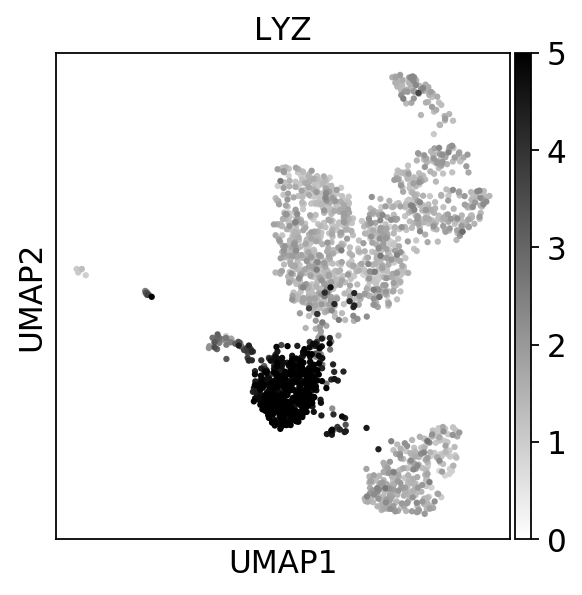

In [597]:
import matplotlib.pylab as plt

gene_name = 'LYZ'
batch_index = 0

sc.pl.umap(adata[adata.obs['batch'] == str(batch_index)],
           color=gene_name,
           color_map=plt.cm.binary,
           use_raw=True,
           save="_" + gene_name + "_" + str(batch_index) + '.pdf',
           vmin=0, vmax=5)

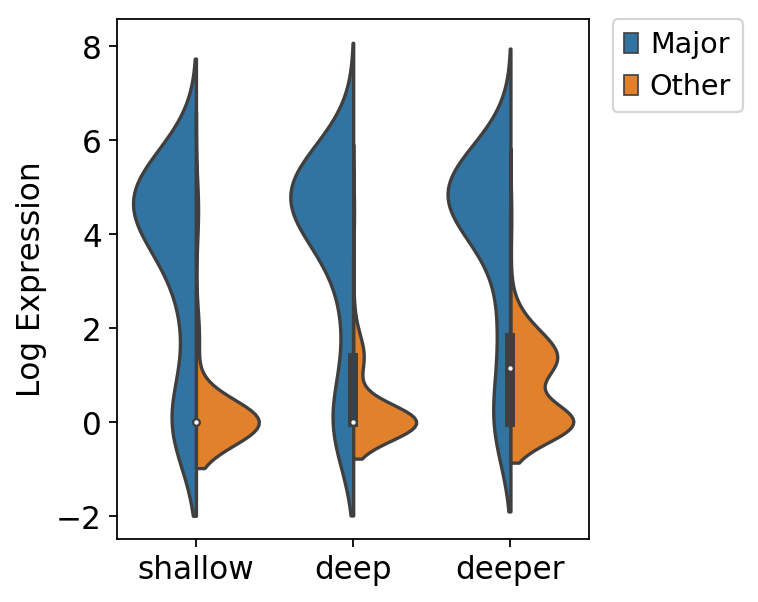

In [598]:
import seaborn as sns

gene_name = 'NKG7'
cell_types = {'Natural killer cell', 'Cytotoxic T cell'}
inc_group_name = "Major"
exc_group_name = "Other"


# gene_name = 'CST3'
# cell_types = {'Plasmacytoid dendritic cell', 'Megakaryoctye', 'CD14+ monocyte', 'CD16+ monocyte'}
# inc_group_name = "Major"
# exc_group_name = "Other"

gene_name = 'LYZ'
cell_types = {'Megakaryoctye', 'CD14+ monocyte', 'CD16+ monocyte'}
inc_group_name = "Major"
exc_group_name = "Other"

batch_names = ('deeper', 'deep', 'shallow')
include_mask = None
exclude_mask = None

for cell_type in cell_types:
    if include_mask is None:
        include_mask = adata.obs['cell_type'] == cell_type
    else:
        include_mask = include_mask | (adata.obs['cell_type'] == cell_type)

for cell_type in cell_types:
    if exclude_mask is None:
        exclude_mask = adata.obs['cell_type'] != cell_type
    else:
        exclude_mask = exclude_mask & (adata.obs['cell_type'] != cell_type)

include_log1p_data = []
exclude_log1p_data = []
for batch_index in range(3):
    include_log1p_data.append(
        np.asarray(adata[(adata.obs['batch'] == str(batch_index)) & include_mask, :].raw.X[
            :, raw_gene_names.tolist().index(gene_name)].todense()).flatten())
    exclude_log1p_data.append(
        np.asarray(adata[(adata.obs['batch'] == str(batch_index)) & exclude_mask, :].raw.X[
            :, raw_gene_names.tolist().index(gene_name)].todense()).flatten())

# columns: batch, group
batch_data = []
group_data = []
expr_data = []


for batch_index, batch_name in enumerate(batch_names):
    for expr in include_log1p_data[batch_index]:
        batch_data.append(batch_name)
        group_data.append(inc_group_name)
        expr_data.append(expr)
    for expr in exclude_log1p_data[batch_index]:
        batch_data.append(batch_name)
        group_data.append(exc_group_name)
        expr_data.append(expr)
        
df = pd.DataFrame(
    data=np.asarray([batch_data, group_data, expr_data]).T,
    columns=["Depth", "Type", "Log Expression"]).astype(
    {"Depth": str, "Type": str, "Log Expression": float})


fig = plt.figure(figsize=(5, 4))
ax = sns.violinplot(
    x="Depth", y="Log Expression", hue="Type",
    data=df, scale='width', split=True,
    hue_order=['Major', 'Other'],
    order=['shallow', 'deep', 'deeper'], bw=0.5)
ax.grid(False)
ax.legend_.remove()
ax.set_xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(f'/home/jupyter/CellBender/proto/chimera/notebooks/figures/violinplot_seq_depth_{gene_name}.pdf')

## Marker genes

In [363]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:09)


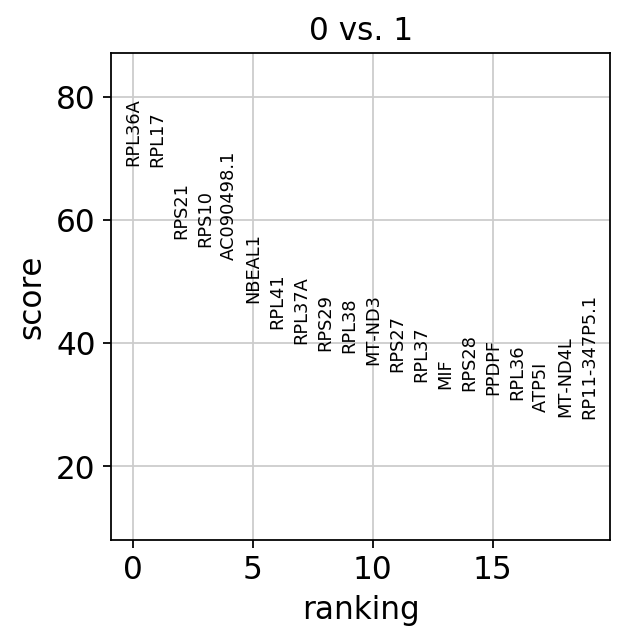

In [364]:
sc.tl.rank_genes_groups(adata, 'batch', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [365]:
adata.write(results_file)

In [366]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [367]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0
0,RPL36A
1,RPL17
2,RPS21
3,RPS10
4,AC090498.1


(1e-200, 1)

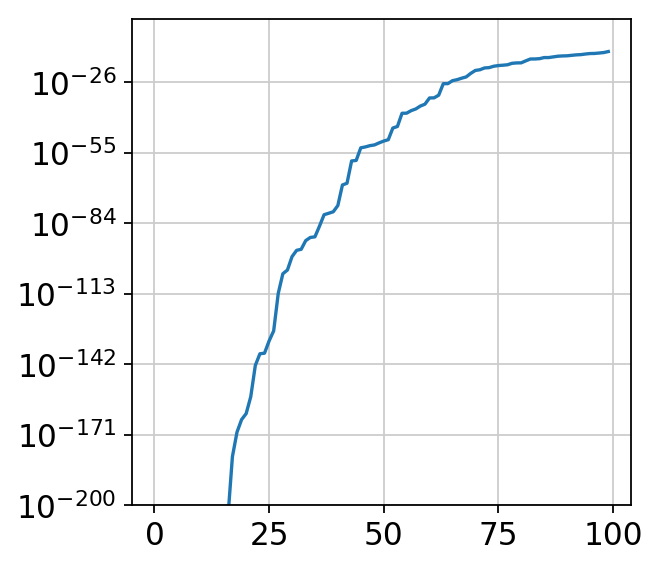

In [368]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

plt.plot(result['pvals_adj'])
plt.yscale('log')
plt.ylim((1e-200, 1))

In [369]:
import matplotlib.pylab as plt

/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


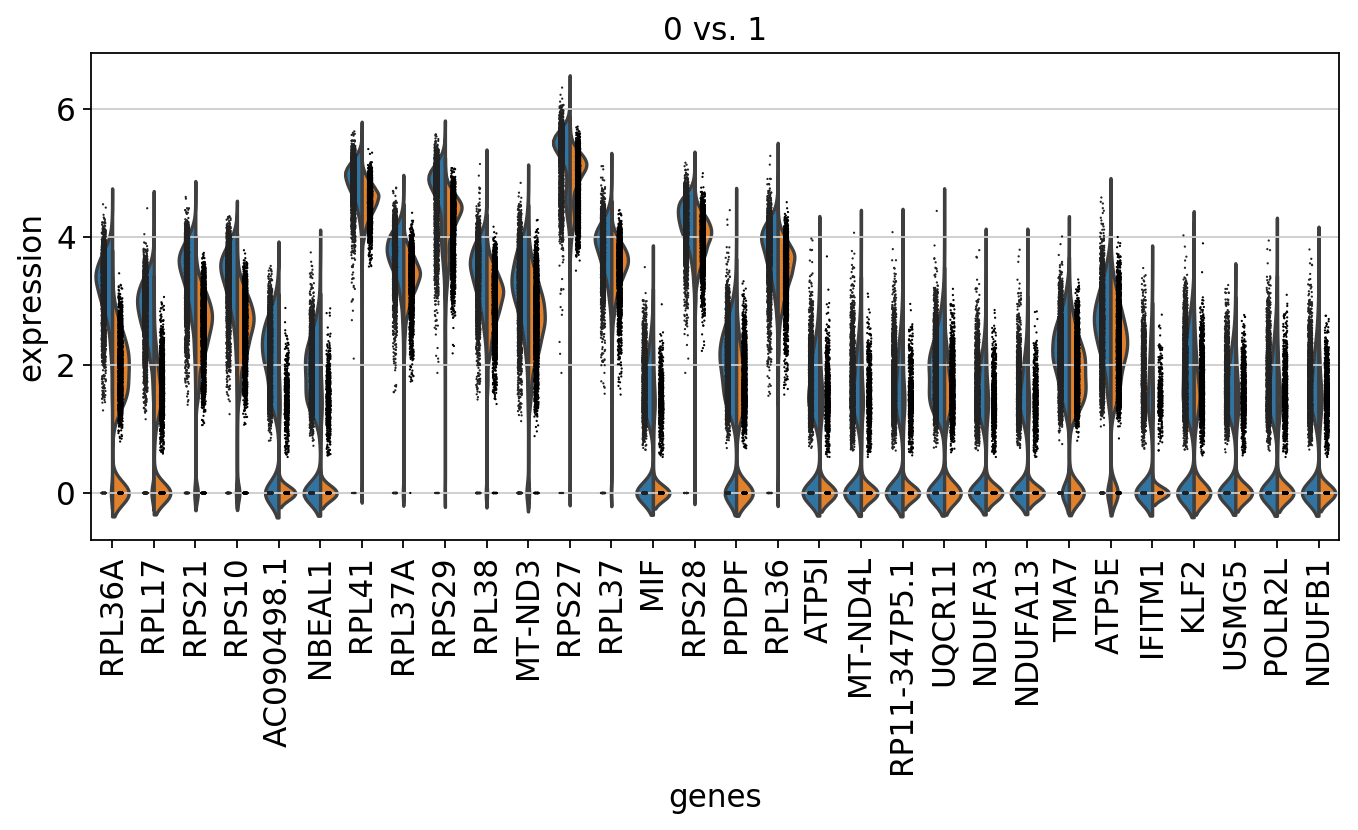

In [370]:
fig = plt.figure(figsize=(10, 4))
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=30, ax=plt.gca(), )

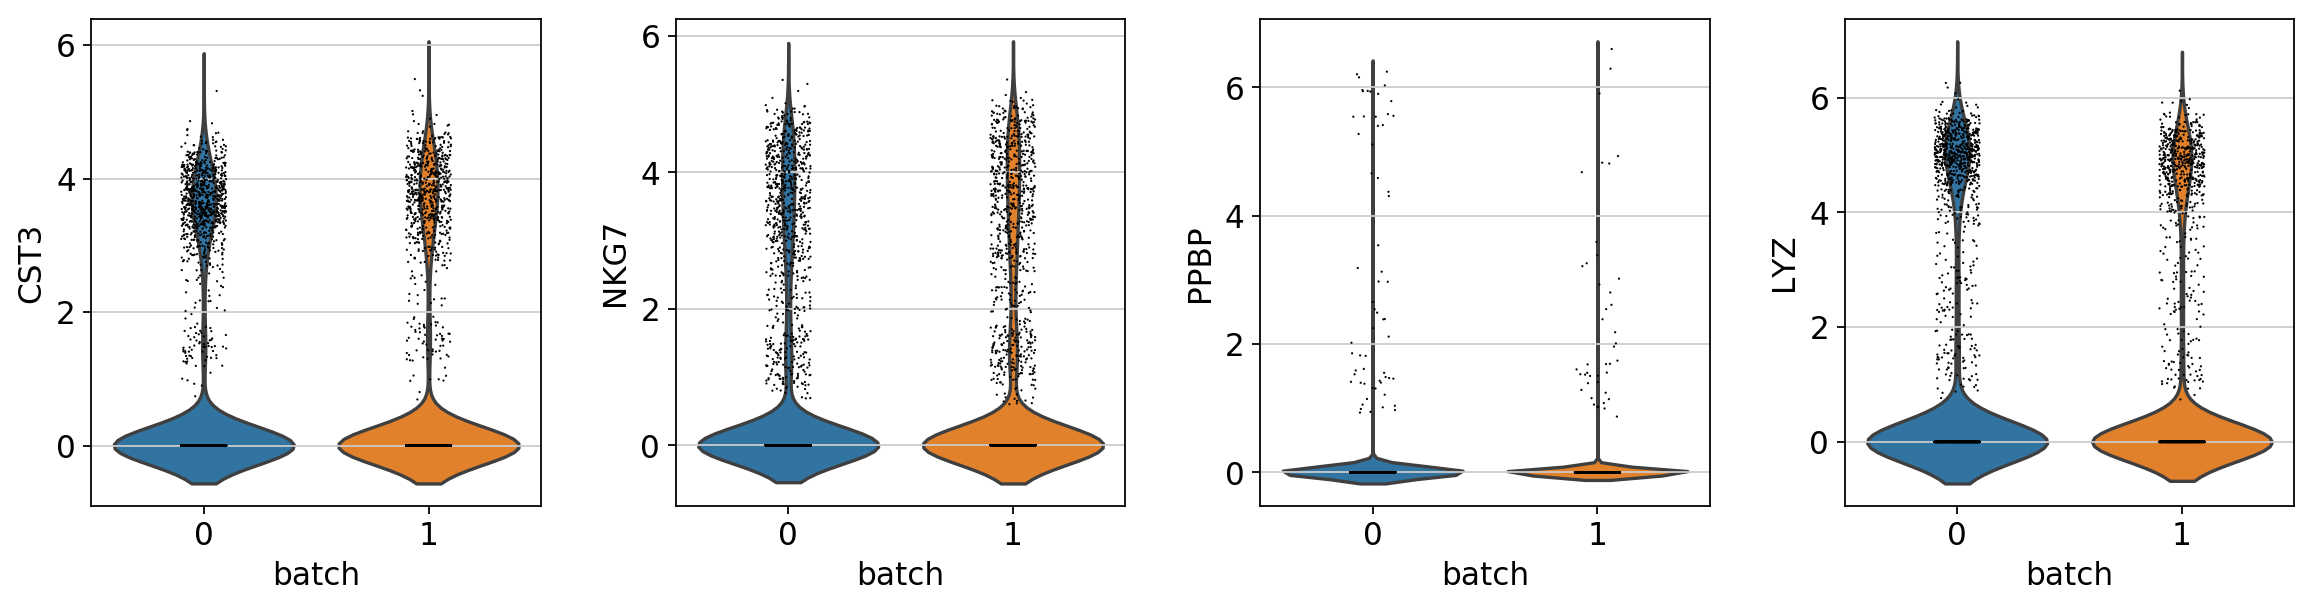

In [371]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP', 'LYZ'], groupby='batch')

In [372]:
# new_cluster_names = [
#     'CD4 T', 'CD14+ Monocytes',
#     'B', 'CD8 T',
#     'NK', 'FCGR3A+ Monocytes',
#     'Dendritic', 'Megakaryocytes']
# adata.rename_categories('louvain', new_cluster_names)

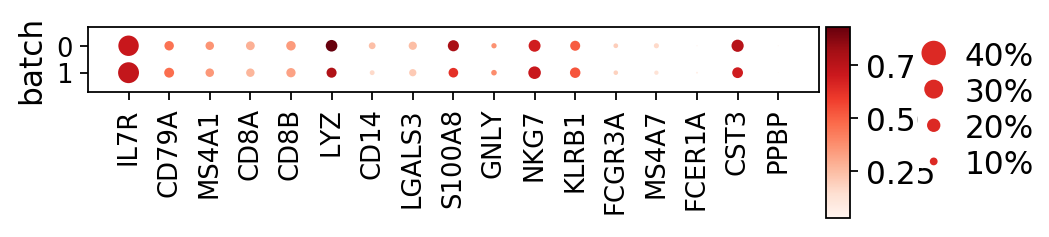

In [373]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='batch', save="_" + output_prefix + '.pdf')

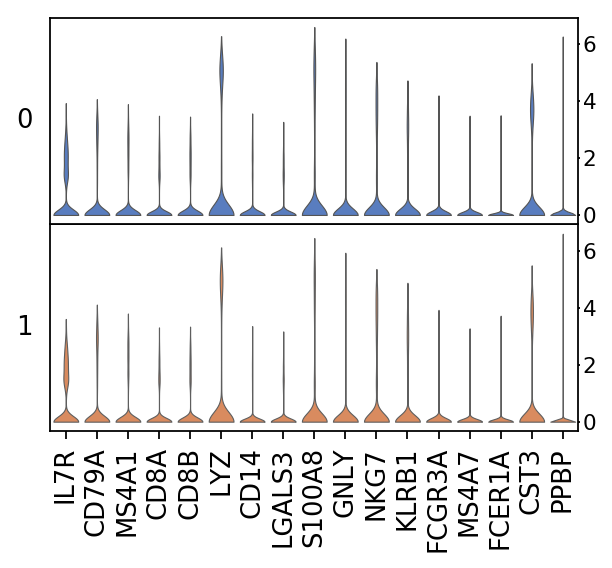

In [374]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='batch', rotation=90, save="_" + output_prefix + '.pdf')

In [375]:
adata

AnnData object with n_obs × n_vars = 7594 × 4062 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'batch_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [1029]:
adata.write(results_file)